In [207]:
# imports:
import numpy as np
import math, os, pickle
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt

import statistics


In [208]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def softmax(A):  
    expA = np.exp(A)
    return expA / expA.sum()

def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)

# functions to use:
def sigmoid(matrix):
    #print("SIGMOID: \n" +str(matrix)+"\n")
    return 1/(1+np.exp(-matrix))

def getInputs(inputs):
    #add bias to layerOne and inputs
    row = inputs.shape[0] if np.ndim(inputs) != 1 else 1
    inputBias = np.ones((row,1)) if np.ndim(inputs) != 1 else np.ones((1))
    inputsWithBias = np.append(inputBias, inputs, 1) if np.ndim(inputs) != 1 else np.append(inputBias, inputs) 
    return inputsWithBias

def networkError(target, netResult):
    print("Target: " + str(target) + " Net Result: " + str(netResult))
    return .5*np.square(target - netResult)

def learning(weights, lr, error, activationsForLayer):
    print("Weights:  " + str(weights.shape))
    print("Learning Rate:  " + str(lr))
    print("Error:  " + str(error.shape))
    print("Activations: "+str(activationsForLayer.shape))
    return weights+lr*error*activationsForLayer

def hiddenUnitError(temp, activations, error):
    return temp*(1-temp)*(activations*error)

def outputError(target, output):
    # Eouput = output(1-output)(target - output)
    return output*(1-output)*(target - output)

def save_it_all(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def saveNet(theta1, theta2, fileName):
    weights = {"theta1":theta1, "theta2":theta2}
    save_it_all(weights, fileName)
    
def sigmoidDerivative(target, output):
    #E = (t − y) * y *  (1− y) // note: derivative of sigmoid func
    return (target - output) * output * (1 - output)

def netPlot(instance, error):
    instance = list(range(0, instance))

    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        fig, ax = plt.subplots()
        ax.plot(instance, error)

        ax.set(xlabel='instance numebr (s)', ylabel='error (net)',
               title='Average Net Error for each batch run')
        ax.grid()

    plt.show()
    
def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)
    
def classifyFish(inputInstance, theta1, theta2):
    # just need to feed forward 
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal)+"\n")
    
    return "Yes" if outputFinal >= .5 else "No"


def getArrayFromFile(name):
    array = genfromtxt(name, delimiter=',')
    return array

In [209]:
# neural Net function:
def nn(learningRate, theta1, theta2, inputInstance, targetInstance):
    
    # feed forward:
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal)+"\n")

    # network error:
    netError = networkError(targetInstance, outputFinal)
    print("\t\tNetwork Error: \n" + str(netError)+"\n")

    # BACKPROPAGATE
    outputErr = outputError(targetInstance, outputFinal[0])
    print("\t\tOutput Error: \n"+str(outputErr)+"\n")

    hidUnitErr = hiddenUnitError(layerOneSig, layerOneActivations, outputErr)
    print("\t\tHidden unit errors: \n"+str(hidUnitErr)+"\n")

    # learning:
    theta1 = learning(theta1, learningRate, hidUnitErr, inputInstance)
    print("\t\tNext round of weights for layerOne: (b,x1,x2) \n"+ str(theta1)+"\n")

    theta2 = learning(theta2, learningRate, outputErr, inputsforhiddenlayer)
    print("\t\tNext round of weights for layer 2: (b,h1,h2) \n"+ str(theta2)+"\n")
    
    return theta1, theta2, netError


In [210]:
#Main:

# load in fishing normalized set 
data = getArrayFromFile("normalizeFish.csv")
inputs = data[:,0:8] # get the input values
targets = data[:, 8:9] # get the class values

inputsWB = getInputs(inputs) # adds bias to the input matrix

numInputNodes = inputsWB.shape[1]
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes)) # + 1 for the bias node

print("Input nodes with bias node: " + str(numInputNodes))
print("Output layer: " + str(numOutputNodes))
print("Hidden nodes with bias node: " + str(numHiddenNodes))

# inititlize weights
# (-1/sqrt(n)) < w < (1/sqrt(n))
lowRange = (-1/math.sqrt(numInputNodes))
highRange = math.fabs(lowRange)
theta1 = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes, numInputNodes))
theta2 = np.random.uniform(low=lowRange, high=highRange, size=(numOutputNodes,numHiddenNodes+1))

print("Theta1 dims: " + str(theta1.shape))
print("Theta2 dims: " + str(theta2.shape))


learningRate = .5
numberProcess = 0
batchError = []
for r in range(0, 100): # batch
    trackedNetError= []
    
    for index in range(0, inputsWB.shape[0]): # online
        print(color.CYAN+color.BOLD+"----------- Data for batch: "+str(r)+" Online Round: "+str(index)+" ------------"+color.END)
        print("Inputs: \n" + str(inputs[index])+"\n")
        print("Learning Rate: \n" + str(learningRate)+"\n")
        print("Theta One: \n" + str(theta1)+"\n")
        print("Theta two: \n" + str(theta2)+"\n")
        print("Target: \n"+ str(targets[index]) + "\n")
        print(color.YELLOW+color.BOLD+"----------Processing on batch:"+str(r)+" with online instance: "+str(index)+"-------------"+color.END)
        theta1, theta2, netError = nn(learningRate, theta1, theta2, np.array([inputsWB[index]]), targets[index])
        trackedNetError.append(netError[0][0])
    numberProcess = numberProcess + 1 
    batchError.append(statistics.mean(trackedNetError))
saveNet(theta1, theta2, "./FishWeights.pkl")


Input nodes with bias node: 9
Output layer: 1
Hidden nodes with bias node: 6
Theta1 dims: (6, 9)
Theta2 dims: (1, 7)
----------- Data for batch: 0 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.01784057  0.07647993  0.20758259 -0.19286671 -0.18933688  0.20648047
   0.09767592 -0.15105265 -0.25994328]
 [ 0.02961352 -0.09462804 -0.09427766 -0.23326594  0.15481638  0.32809086
   0.28921747  0.04185823 -0.30968348]
 [-0.23685526 -0.21727793 -0.17069269  0.31068042  0.28938486 -0.11213431
  -0.14845573 -0.0745247   0.13416898]
 [-0.10272334  0.12721144 -0.27281529 -0.11859574  0.28862588 -0.19845656
   0.24208704  0.17243457 -0.06094739]
 [-0.2007223   0.05377174 -0.26343265  0.31819865 -0.18168293  0.31482444
  -0.1442082  -0.06337019 -0.01126777]
 [-0.13608789 -0.17346502  0.18192042 -0.00833293 -0.33123    -0.07376793
   0.02437138  0.02512056  0.20930334]]

Theta two: 
[[ 0.08742503 -0.24244109  0.32510969  0.00707584  0.29444328  


Learning Rate: 
0.5

Theta One: 
[[ 0.04422341  0.06864986  0.21498662 -0.18466251 -0.17856227  0.24343884
   0.10119214 -0.147399   -0.24073031]
 [ 0.04677994 -0.09919051 -0.08038337 -0.21236122  0.13718377  0.33934273
   0.31103691  0.04174339 -0.31422167]
 [-0.26170774 -0.17902461 -0.18942517  0.29496842  0.29897685 -0.13186187
  -0.15954421 -0.09382851  0.13970879]
 [-0.11434361  0.12316689 -0.29429898 -0.10528502  0.28517858 -0.19575852
   0.22522543  0.16348435 -0.04675582]
 [-0.22432311  0.09267662 -0.28566229  0.31140104 -0.17625649  0.30846471
  -0.1364318  -0.08436912 -0.02164604]
 [-0.10034903 -0.14827119  0.19395858 -0.02220324 -0.293659   -0.04564484
   0.02322146  0.02901172  0.24230095]]

Theta two: 
[[ 0.11489727 -0.20214938  0.35751186 -0.0031086   0.29667181  0.19660786
  -0.15564418]]

Target: 
[0.]

----------Processing on batch:2 with online instance: 5-------------
		Layer One activations: 
[[-0.06298047]
 [ 0.10989427]
 [-0.13390858]
 [ 0.05148752]
 [-0.02108431


Theta two: 
[[ 0.12561344 -0.1658845   0.40219731 -0.03436445  0.29873928  0.17622409
  -0.13321967]]

Target: 
[1.]

----------Processing on batch:4 with online instance: 12-------------
		Layer One activations: 
[[ 0.68944486]
 [ 0.72181441]
 [-0.84774222]
 [-0.41667482]
 [-0.38319341]
 [ 0.10798025]]

		Sigmoid Result: [[0.66584342]
 [0.67300644]
 [0.29990669]
 [0.39731271]
 [0.40535692]
 [0.52696886]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.66584342 0.67300644 0.29990669 0.39731271 0.40535692
  0.52696886]]

		Activation for output layer: (h1,h2)
[[0.39545954]]

		Final output: 
[[0.59759628]]

Target: [1.] Net Result: [[0.59759628]]
		Network Error: 
[[0.08096438]]

		Output Error: 
[0.09676802]

		Hidden unit errors: 
[[ 0.01484409]
 [ 0.01537149]
 [-0.01722415]
 [-0.00965503]
 [-0.00893807]
 [ 0.00260466]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.08198051  0.0628036   0.23327362 -0.16341917 -0.18033551  0.28099806
   0.12288085 -0.14368105 -0.22


		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.10763575  0.04751281  0.24566645 -0.14579988 -0.1846924   0.30326232
   0.13788693 -0.1360742  -0.22533757]
 [ 0.13205121 -0.11274597 -0.03951844 -0.1278438   0.09707272  0.37555579
   0.39356034  0.0475227  -0.31725312]
 [-0.34357946 -0.11280006 -0.24383681  0.23744249  0.3290427  -0.17632008
  -0.22652633 -0.13186557  0.16285624]
 [-0.13888557  0.1185133  -0.34041661 -0.07039633  0.27186555 -0.20124688
   0.18440861  0.14481975 -0.01181637]
 [-0.28766733  0.16849345 -0.33796477  0.29123697 -0.16713416  0.29041091
  -0.1339241  -0.12431699 -0.04755009]
 [-0.06707472 -0.11915548  0.21808813 -0.06295434 -0.24376313 -0.01709404
   0.01669225  0.03944376  0.27167244]]

		Next round of weights for layer 2: (b,h1,h2) 
[[ 0.17773996 -0.10531428  0.48043995 -0.05656788  0.30334976  0.16055161
  -0.08966952]]

----------- Data for batch: 7 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 


		Final output: 
[[0.56283789]]

Target: [0.] Net Result: [[0.56283789]]
		Network Error: 
[[0.15839325]]

		Output Error: 
[-0.13848705]

		Hidden unit errors: 
[[-0.00338641]
 [-0.0045066 ]
 [ 0.00652967]
 [ 0.01391053]
 [-0.00699505]
 [-0.00471092]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.13173755  0.02575886  0.26116144 -0.12588344 -0.19600202  0.31730878
   0.16199486 -0.12952893 -0.23188896]
 [ 0.16713972 -0.13714375 -0.02025911 -0.08074156  0.06579965  0.37429051
   0.44546609  0.05243068 -0.33897834]
 [-0.38262656 -0.07418628 -0.26997362  0.20473199  0.34884291 -0.18382443
  -0.26948447 -0.14956357  0.18446528]
 [-0.14811076  0.11557461 -0.36078461 -0.0538275   0.26643954 -0.19982162
   0.16266727  0.13568284  0.0098367 ]
 [-0.31925914  0.20218327 -0.36277459  0.27635885 -0.15903803  0.28471471
  -0.14341975 -0.14231337 -0.05164988]
 [-0.05815617 -0.1061384   0.22890031 -0.08475465 -0.22385645 -0.0074131
   0.01439598  0.04472395  0.27760706]]

		Next round of w

Target: [0.] Net Result: [[0.62365304]]
		Network Error: 
[[0.19447156]]

		Output Error: 
[-0.14637756]

		Hidden unit errors: 
[[-0.02346831]
 [-0.02226306]
 [ 0.03125389]
 [ 0.01146249]
 [ 0.02263215]
 [-0.00295223]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.17982084  0.01194038  0.28301786 -0.08974809 -0.2059105   0.35034835
   0.20910297 -0.12168348 -0.23875923]
 [ 0.24151485 -0.13734926  0.00706655 -0.01114739  0.04325494  0.40294762
   0.52611372  0.05909085 -0.35191103]
 [-0.44987328 -0.0448468  -0.30249094  0.15557222  0.36327329 -0.21837116
  -0.34094969 -0.16868095  0.20780116]
 [-0.17047554  0.12499679 -0.38794717 -0.04643342  0.26384325 -0.21287717
   0.13496171  0.12546068  0.02539964]
 [-0.35198455  0.2474221  -0.39356061  0.26855577 -0.15317434  0.27878718
  -0.1531738  -0.16143897 -0.05549563]
 [-0.05909771 -0.1137191   0.24297462 -0.11039632 -0.21323064 -0.00587283
   0.00474388  0.050545    0.28049658]]

		Next round of weights for layer 2: (b,h1,h2) 
[[


----------Processing on batch:14 with online instance: 8-------------
		Layer One activations: 
[[ 0.57702146]
 [ 1.25457177]
 [-0.72818995]
 [-0.04995202]
 [-0.41967103]
 [-0.24079658]]

		Sigmoid Result: [[0.64038176]
 [0.77809025]
 [0.32559206]
 [0.48751459]
 [0.39659547]
 [0.44009006]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.64038176 0.77809025 0.32559206 0.48751459 0.39659547
  0.44009006]]

		Activation for output layer: (h1,h2)
[[0.25077187]]

		Final output: 
[[0.56236648]]

Target: [1.] Net Result: [[0.56236648]]
		Network Error: 
[[0.09576155]]

		Output Error: 
[0.10770617]

		Hidden unit errors: 
[[ 0.01431242]
 [ 0.02333149]
 [-0.01722193]
 [-0.0013442 ]
 [-0.01081698]
 [-0.00639073]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 2.17641188e-01 -1.62819449e-02  3.06643671e-01 -5.79243764e-02
  -2.23539677e-01  3.60365149e-01  2.51179648e-01 -1.07255925e-01
  -2.57443115e-01]
 [ 2.95476562e-01 -1.68723729e-01  3.29977095e-02  5.27372768e-02
   7.4

----------Processing on batch:16 with online instance: 13-------------
		Layer One activations: 
[[-0.03574852]
 [-0.08141564]
 [-0.28096876]
 [-0.07873032]
 [ 0.05703706]
 [-0.05601052]]

		Sigmoid Result: [[0.49106382]
 [0.47965732]
 [0.43021629]
 [0.48032758]
 [0.5142554 ]
 [0.48600103]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.49106382 0.47965732 0.43021629 0.48032758 0.5142554
  0.48600103]]

		Activation for output layer: (h1,h2)
[[0.32151891]]

		Final output: 
[[0.57969438]]

Target: [0.] Net Result: [[0.57969438]]
		Network Error: 
[[0.16802279]]

		Output Error: 
[-0.14124184]

		Hidden unit errors: 
[[ 0.00126189]
 [ 0.00287007]
 [ 0.00972788]
 [ 0.0027757 ]
 [-0.00201237]
 [ 0.00197621]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.27831892 -0.01901177  0.33589484 -0.01320085 -0.23683664  0.3877565
   0.32224669 -0.09575731 -0.27933104]
 [ 0.37628519 -0.16218803  0.0644914   0.12680583 -0.01735279  0.41810286
   0.70060784  0.08403455 -0.4165785 


Target: 
[0.]

----------Processing on batch:19 with online instance: 5-------------
		Layer One activations: 
[[ 0.10578354]
 [ 0.14300439]
 [-0.12377248]
 [ 0.00448261]
 [-0.01955053]
 [-0.07822313]]

		Sigmoid Result: [[0.52642125]
 [0.5356903 ]
 [0.46909632]
 [0.50112065]
 [0.49511252]
 [0.48045418]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.52642125 0.5356903  0.46909632 0.50112065 0.49511252
  0.48045418]]

		Activation for output layer: (h1,h2)
[[0.12504301]]

		Final output: 
[[0.53122009]]

Target: [0.] Net Result: [[0.53122009]]
		Network Error: 
[[0.14109739]]

		Output Error: 
[-0.13228724]

		Hidden unit errors: 
[[-0.00348868]
 [-0.00470532]
 [ 0.00407774]
 [-0.00014825]
 [ 0.00064651]
 [ 0.00258303]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.31905708 -0.0552766   0.35739398  0.02513033 -0.25592881  0.39446851
   0.36880562 -0.07565076 -0.30525835]
 [ 0.42515552 -0.19965671  0.08727303  0.18644591 -0.05090416  0.41015132
   0.76590566  0.104


		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.69401738 0.79805249 0.20588652 0.45022886 0.44418011
  0.38544728]]

		Activation for output layer: (h1,h2)
[[0.39573756]]

		Final output: 
[[0.59766313]]

Target: [1.] Net Result: [[0.59766313]]
		Network Error: 
[[0.08093748]]

		Output Error: 
[0.09674669]

		Hidden unit errors: 
[[ 0.0168256 ]
 [ 0.02142622]
 [-0.02135249]
 [-0.00478332]
 [-0.00535541]
 [-0.01069062]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.38415545 -0.07015342  0.37750962  0.08823413 -0.27404987  0.40315116
   0.45038374 -0.06043299 -0.33695587]
 [ 0.49960318 -0.21570263  0.10748574  0.26854068 -0.07876398  0.4057574
   0.86457778  0.12017578 -0.49337168]
 [-0.7373005   0.08264564 -0.43987772 -0.07805088  0.44685595 -0.25010127
  -0.65990048 -0.27920795  0.34985173]
 [-0.30020871  0.16181956 -0.50180543 -0.06435764  0.26589255 -0.23845194
  -0.0065659   0.05642872  0.10622604]
 [-0.5479885   0.3991341  -0.53584362  0.17846562 -0.11680513  0


Theta two: 
[[ 0.02251603  0.21848782  1.0178946  -0.76963202 -0.00476099 -0.31257075
  -0.17338335]]

Target: 
[0.]

----------Processing on batch:24 with online instance: 4-------------
		Layer One activations: 
[[ 0.2071015 ]
 [ 0.34477864]
 [-0.21305788]
 [-0.20894431]
 [-0.48445072]
 [ 0.05925507]]

		Sigmoid Result: [[0.55159111]
 [0.58535084]
 [0.44693611]
 [0.44795314]
 [0.3812017 ]
 [0.51480944]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.55159111 0.58535084 0.44693611 0.44795314 0.3812017
  0.51480944]]

		Activation for output layer: (h1,h2)
[[0.18433651]]

		Final output: 
[[0.54595407]]

Target: [0.] Net Result: [[0.54595407]]
		Network Error: 
[[0.14903293]]

		Output Error: 
[-0.13533559]

		Hidden unit errors: 
[[-0.00693245]
 [-0.01132529]
 [ 0.00712739]
 [ 0.0069928 ]
 [ 0.01546556]
 [-0.00200307]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.43924454 -0.11155772  0.4059757   0.13416945 -0.29336218  0.41258015
   0.5085612  -0.03525134 -0.36


Theta two: 
[[-0.16815822  0.18637968  1.01181875 -0.95835967 -0.13876585 -0.47424566
  -0.27876487]]

Target: 
[1.]

----------Processing on batch:26 with online instance: 10-------------
		Layer One activations: 
[[ 1.48053503]
 [ 2.0244355 ]
 [-1.84082936]
 [-0.60811827]
 [-0.13901377]
 [-0.59503534]]

		Sigmoid Result: [[0.81465338]
 [0.88333887]
 [0.13695324]
 [0.35248857]
 [0.46530242]
 [0.35548035]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.81465338 0.88333887 0.13695324 0.35248857 0.46530242
  0.35548035]]

		Activation for output layer: (h1,h2)
[[0.37752852]]

		Final output: 
[[0.59327688]]

Target: [1.] Net Result: [[0.59327688]]
		Network Error: 
[[0.08271185]]

		Output Error: 
[0.09814206]

		Hidden unit errors: 
[[ 0.02193973]
 [ 0.02047447]
 [-0.02135381]
 [-0.01362184]
 [-0.00339435]
 [-0.0133798 ]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.49334296 -0.14139465  0.42326774  0.19145258 -0.31383893  0.4100308
   0.58195268 -0.01720205 -0.40


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.10352193  0.33713247  1.19395128 -1.07550239 -0.18169277 -0.53665488
  -0.26698828]]

----------- Data for batch: 29 Online Round: 1 ------------
Inputs: 
[1. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.55772894 -0.16292384  0.45305349  0.2417569  -0.32954302  0.41395998
   0.65667028  0.00157433 -0.43167625]
 [ 0.6623357  -0.31717052  0.17937774  0.43473471 -0.15411749  0.3803895
   1.06511907  0.18333481 -0.59433949]
 [-0.91082079  0.20806311 -0.52393003 -0.22412627  0.50346336 -0.23909667
  -0.86551763 -0.35881063  0.46155127]
 [-0.44398799  0.22179697 -0.59456733 -0.1320222   0.28253973 -0.26200299
  -0.16036247 -0.00763198  0.18030402]
 [-0.72559217  0.51386831 -0.63555561  0.06743609 -0.08366729  0.26891483
  -0.40640236 -0.34961448  0.01230082]
 [-0.10001319 -0.13287675  0.34801466 -0.32474993 -0.14483253 -0.00989792
  -0.14212863  0.11585004  0.32114857]]

Theta two: 
[[-0.10352193  0.33713247  1.19395128 -1


Target: [1.] Net Result: [[0.62490409]]
		Network Error: 
[[0.07034847]]

		Output Error: 
[0.08792209]

		Hidden unit errors: 
[[ 0.01968313]
 [ 0.01718738]
 [-0.01803786]
 [-0.01528551]
 [-0.01852052]
 [-0.01235893]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.58866872 -0.22383645  0.45903846  0.29959148 -0.36242279  0.39065213
   0.68032134  0.0305751  -0.4533883 ]
 [ 0.68635264 -0.38052388  0.18423733  0.49119984 -0.19142527  0.34796541
   1.07827244  0.21247375 -0.61261485]
 [-0.94493251  0.27281832 -0.5333643  -0.28050474  0.53516438 -0.21133386
  -0.8846557  -0.39088691  0.4786539 ]
 [-0.48146614  0.26326572 -0.60764345 -0.17301319  0.29912869 -0.25330236
  -0.18699661 -0.03720565  0.19903368]
 [-0.76873618  0.56882614 -0.6472016   0.011553   -0.05928221  0.28722795
  -0.42876983 -0.38204285  0.02395266]
 [-0.10517806 -0.12227748  0.36573295 -0.36470527 -0.12776037 -0.00225499
  -0.1662668   0.12895133  0.32702057]]

		Next round of weights for layer 2: (b,h1,h2) 
[[


		Activation for output layer: (h1,h2)
[[-0.25234292]]

		Final output: 
[[0.43724691]]

Target: [0.] Net Result: [[0.43724691]]
		Network Error: 
[[0.09559243]]

		Output Error: 
[-0.10758987]

		Hidden unit errors: 
[[-0.00707377]
 [-0.00598647]
 [ 0.01289787]
 [ 0.00629827]
 [ 0.00586247]
 [ 0.00886129]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.64279388 -0.23966905  0.47525748  0.34171617 -0.36664134  0.39544908
   0.75274032  0.05015047 -0.49125749]
 [ 0.7317688  -0.39941728  0.19900438  0.52873286 -0.19830919  0.34376914
   1.13915165  0.23204801 -0.64765217]
 [-0.9898238   0.29692819 -0.54897247 -0.31261528  0.53799179 -0.20983137
  -0.95013195 -0.41136975  0.51972169]
 [-0.53138649  0.27494864 -0.62896167 -0.20222746  0.29974082 -0.26212674
  -0.25174733 -0.05712798  0.23378639]
 [-0.82458826  0.59332217 -0.6667996  -0.02595782 -0.05802547  0.28176101
  -0.48825807 -0.40278385  0.04832981]
 [-0.12810238 -0.13090247  0.37882635 -0.40488291 -0.12360045 -0.01160811
 


		Activation for output layer: (h1,h2)
[[-1.01695949]]

		Final output: 
[[0.26562008]]

Target: [0.] Net Result: [[0.26562008]]
		Network Error: 
[[0.03527701]]

		Output Error: 
[-0.05181346]

		Hidden unit errors: 
[[ 0.00149803]
 [ 0.0030496 ]
 [-0.0026762 ]
 [-0.00060126]
 [-0.001103  ]
 [ 0.00055766]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.67958936 -0.28794119  0.48352124  0.38540727 -0.38180072  0.38314529
   0.77427962  0.07943427 -0.50528511]
 [ 0.76367334 -0.44898366  0.20591361  0.5707845  -0.21536551  0.32589861
   1.15060998  0.26124265 -0.65640059]
 [-1.02782318  0.34614027 -0.55788749 -0.35469289  0.55098504 -0.19513059
  -0.96710081 -0.44068039  0.52800182]
 [-0.57213482  0.31397851 -0.64219803 -0.24011547  0.31011686 -0.25618642
  -0.27811545 -0.08688663  0.24916483]
 [-0.86737934  0.64056044 -0.67642739 -0.07496853 -0.04217805  0.29483382
  -0.50977318 -0.43244238  0.05671238]
 [-0.13620229 -0.12539452  0.39836637 -0.44057943 -0.11554386 -0.01184775
 


Learning Rate: 
0.5

Theta One: 
[[ 0.71270595 -0.31958392  0.49027489  0.4298404  -0.39987091  0.36122714
   0.81890885  0.09870888 -0.53607237]
 [ 0.78604178 -0.48545     0.21165878  0.60897184 -0.23692958  0.29596362
   1.18111817  0.28042551 -0.68372321]
 [-1.05358832  0.38239319 -0.56416526 -0.39169147  0.56849625 -0.16847205
  -1.00408203 -0.45928097  0.55781848]
 [-0.61383536  0.3325813  -0.65223547 -0.27985358  0.31819188 -0.24691473
  -0.33114159 -0.10644014  0.28004394]
 [-0.91256474  0.66818225 -0.68355308 -0.12144899 -0.03375731  0.30662417
  -0.55855984 -0.45122153  0.07909278]
 [-0.15750528 -0.12545922  0.41166857 -0.48930975 -0.10141871 -0.00851758
  -0.28243644  0.15979474  0.36001959]]

Theta two: 
[[-0.27146884  0.56196499  1.49750144 -1.5638361  -0.49665905 -0.94243341
  -0.42697749]]

Target: 
[1.]

----------Processing on batch:38 with online instance: 12-------------
		Layer One activations: 
[[ 2.38311683]
 [ 2.47478236]
 [-2.79030767]
 [-1.84412715]
 [-1.848053


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.26399086  0.63388549  1.58393201 -1.64563526 -0.5540547  -1.02415395
  -0.43041743]]

----------- Data for batch: 41 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.74360993 -0.37357374  0.49736193  0.4658234  -0.41203697  0.35121319
   0.83186946  0.12701206 -0.54643218]
 [ 0.81279783 -0.5412457   0.21736778  0.6443916  -0.2513023   0.28097205
   1.18430353  0.30857532 -0.68830232]
 [-1.08084446  0.43899944 -0.57019572 -0.424222    0.5798011  -0.1550693
  -1.01273058 -0.48581833  0.56574825]
 [-0.65311285  0.37792506 -0.66352033 -0.31492409  0.32526976 -0.24530545
  -0.35379039 -0.1350886   0.29206371]
 [-0.9544392   0.71897739 -0.68999737 -0.16556476 -0.0250717   0.3110908
  -0.57696068 -0.4779232   0.08232082]
 [-0.15914626 -0.11193261  0.43191158 -0.52012502 -0.09248744 -0.00604203
  -0.30582342  0.17306164  0.36849868]]

Theta two: 
[[-0.26399086  0.63388549  1.58393201 -1.


		Output Error: 
[0.07306083]

		Hidden unit errors: 
[[ 0.01542316]
 [ 0.01386472]
 [-0.01456005]
 [-0.01558771]
 [-0.01106738]
 [-0.01522898]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 7.57624896e-01 -4.14217384e-01  5.00162342e-01  4.93997459e-01
  -4.28996474e-01  3.25009633e-01  8.55559273e-01  1.45384698e-01
  -5.74479655e-01]
 [ 8.18345855e-01 -5.86013029e-01  2.19342471e-01  6.68476841e-01
  -2.71814202e-01  2.48042280e-01  1.19559101e+00  3.26847918e-01
  -7.12314381e-01]
 [-1.08964233e+00  4.82274882e-01 -5.72115020e-01 -4.47058561e-01
   5.95759096e-01 -1.25823118e-01 -1.03064140e+00 -5.02642941e-01
   5.91685817e-01]
 [-6.77615877e-01  4.05300357e-01 -6.68701320e-01 -3.44043796e-01
   3.35067426e-01 -2.29499362e-01 -3.91204815e-01 -1.53635098e-01
   3.23521605e-01]
 [-9.78440191e-01  7.52203433e-01 -6.91753900e-01 -1.99271748e-01
  -1.36091745e-02  3.30200613e-01 -6.10706654e-01 -4.94784114e-01
   1.08926724e-01]
 [-1.69654239e-01 -1.01961260e-01  4.45589286e-01


----------- Data for batch: 46 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.77047318 -0.46086069  0.49285919  0.52449689 -0.43934447  0.31292073
   0.86625584  0.16331567 -0.59025891]
 [ 0.82637373 -0.63554166  0.21099295  0.69773884 -0.2846988   0.23159364
   1.19699198  0.34468718 -0.72352673]
 [-1.09724584  0.53107287 -0.56422251 -0.47240436  0.60560887 -0.1109128
  -1.03767201 -0.51881376  0.60728374]
 [-0.6976064   0.44524129 -0.66441918 -0.37410949  0.34086045 -0.22504755
  -0.41179965 -0.17169139  0.34218221]
 [-0.99786844  0.79585793 -0.68319937 -0.23368265 -0.00718105  0.33623198
  -0.62797537 -0.51093368  0.12291676]
 [-0.1757614  -0.09351285  0.46189575 -0.5885945  -0.07061726  0.00417841
  -0.36481061  0.19080724  0.39312514]]

Theta two: 
[[-0.42858107  0.65575955  1.63122355 -1.85422418 -0.72066874 -1.22266725
  -0.54640163]]

Target: 
[1.]

----------Processing on batch:46 with online instance: 2-------------
		L

		Layer One activations: 
[[ 1.48349998]
 [ 1.9194678 ]
 [-1.60546536]
 [-1.01011674]
 [-1.30914481]
 [-0.59204751]]

		Sigmoid Result: [[0.81510065]
 [0.87207907]
 [0.16721914]
 [0.266957  ]
 [0.21262998]
 [0.3561652 ]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.81510065 0.87207907 0.16721914 0.266957   0.21262998
  0.3561652 ]]

		Activation for output layer: (h1,h2)
[[0.64566791]]

		Final output: 
[[0.65603357]]

Target: [1.] Net Result: [[0.65603357]]
		Network Error: 
[[0.05915645]]

		Output Error: 
[0.07761724]

		Hidden unit errors: 
[[ 0.01735371]
 [ 0.01662021]
 [-0.01735305]
 [-0.01534265]
 [-0.01701176]
 [-0.01053757]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 8.03632216e-01 -5.08339223e-01  5.00939397e-01  5.63422896e-01
  -4.53191646e-01  2.92800480e-01  8.74966356e-01  1.89344257e-01
  -5.91838977e-01]
 [ 8.53924628e-01 -6.87112773e-01  2.18417446e-01  7.35702712e-01
  -3.02536275e-01  2.06004604e-01  1.19531526e+00  3.70600733e-01
  -7.202126


Theta two: 
[[-0.4034719   0.80473506  1.80369953 -2.00618781 -0.82791073 -1.36944315
  -0.56966234]]

Target: 
[0.]

----------Processing on batch:51 with online instance: 1-------------
		Layer One activations: 
[[ 1.69815664]
 [ 1.59069526]
 [-2.16983774]
 [-1.42156781]
 [-1.58561789]
 [-0.1962223 ]]

		Sigmoid Result: [[0.84529383]
 [0.8307139 ]
 [0.10249196]
 [0.19441592]
 [0.17000132]
 [0.45110122]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.84529383 0.8307139  0.10249196 0.19441592 0.17000132
  0.45110122]]

		Activation for output layer: (h1,h2)
[[0.91876428]]

		Final output: 
[[0.71479025]]

Target: [0.] Net Result: [[0.71479025]]
		Network Error: 
[[0.25546255]]

		Output Error: 
[-0.14572082]

		Hidden unit errors: 
[[-0.03236046]
 [-0.03259728]
 [ 0.02908553]
 [ 0.03244381]
 [ 0.03260242]
 [ 0.00708005]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.80486787 -0.54700492  0.48927384  0.58428903 -0.46115656  0.27384758
   0.88629892  0.20611149 -0.6


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.47759322  0.79378978  1.80212136 -2.080032   -0.89444747 -1.45553019
  -0.60831081]]

----------- Data for batch: 53 Online Round: 7 ------------
Inputs: 
[0. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.82370523 -0.59172743  0.4936922   0.61692665 -0.47937519  0.24739102
   0.88024799  0.23040143 -0.61810477]
 [ 0.86600931 -0.77833376  0.21009891  0.78876755 -0.3351979   0.15143357
   1.18403419  0.41153688 -0.73778308]
 [-1.14107329  0.66674548 -0.55973514 -0.55949974  0.64438943 -0.03892922
  -1.04197029 -0.57770931  0.62665011]
 [-0.77734474  0.5477561  -0.67078959 -0.4702797   0.36366273 -0.1837991
  -0.46243404 -0.23879913  0.380186  ]
 [-1.07866074  0.90660436 -0.67608826 -0.34443886  0.01567175  0.3805426
  -0.67209915 -0.56924692  0.14456149]
 [-0.1849967  -0.05661352  0.51565104 -0.68796845 -0.03423392  0.03319298
  -0.42735006  0.22656681  0.41066971]]

Theta two: 
[[-0.47759322  0.79378978  1.80212136 -2.


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.50766592  0.81971512  1.84047133 -2.14409489 -0.94232978 -1.52191362
  -0.63857986]]

----------- Data for batch: 55 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.83186363 -0.62361153  0.48879518  0.62665732 -0.47605043  0.22767661
   0.89662331  0.24604258 -0.64196284]
 [ 0.87047683 -0.81312299  0.20498862  0.79787976 -0.33473229  0.1281478
   1.19342982  0.42715458 -0.75832887]
 [-1.1458489   0.6995798  -0.55338886 -0.56702535  0.64079316 -0.01749013
  -1.05584559 -0.59117664  0.64921713]
 [-0.79104424  0.57381506 -0.667169   -0.48149994  0.35756288 -0.16847273
  -0.48678982 -0.25433755  0.4063807 ]
 [-1.09351724  0.93474274 -0.66896166 -0.3589025   0.00815229  0.39425568
  -0.69506784 -0.58246934  0.16589609]
 [-0.18983766 -0.04977047  0.52992836 -0.70834859 -0.03297205  0.04159151
  -0.45526594  0.23556963  0.42474181]]

Theta two: 
[[-0.50766592  0.81971512  1.84047133 -

		Sigmoid Result: [[0.55532834]
 [0.53054021]
 [0.40418469]
 [0.41789859]
 [0.40372737]
 [0.36006098]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.55532834 0.53054021 0.40418469 0.41789859 0.40372737
  0.36006098]]

		Activation for output layer: (h1,h2)
[[-1.0604092]]

		Final output: 
[[0.25723126]]

Target: [0.] Net Result: [[0.25723126]]
		Network Error: 
[[0.03308396]]

		Output Error: 
[-0.04914746]

		Hidden unit errors: 
[[-0.002697  ]
 [-0.00149724]
 [ 0.00459293]
 [ 0.00396215]
 [ 0.00461373]
 [ 0.00651267]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.85562474 -0.6435292   0.4855221   0.65754308 -0.479902    0.22357346
   0.91600782  0.26126559 -0.65280924]
 [ 0.89180176 -0.83587161  0.20171165  0.82880178 -0.34105241  0.12067832
   1.20662639  0.44236736 -0.7654133 ]
 [-1.16517255  0.72188251 -0.5481929  -0.5951189   0.64436709 -0.01145389
  -1.0724484  -0.60421635  0.659536  ]
 [-0.81987384  0.58886148 -0.66542095 -0.51267398  0.35815927 -0.1695544


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.46728422  0.94503247  1.9905544  -2.24528288 -1.01512405 -1.6226509
  -0.65842581]]

----------- Data for batch: 60 Online Round: 5 ------------
Inputs: 
[1. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.86945852 -0.68988093  0.47221177  0.68719756 -0.48241237  0.21080713
   0.90600766  0.28336861 -0.65107832]
 [ 0.90455479 -0.88459269  0.18849922  0.859484   -0.34576917  0.10526862
   1.19173355  0.46447739 -0.75987745]
 [-1.17797488  0.76767031 -0.53276005 -0.62536402  0.64637704  0.00227101
  -1.06146394 -0.62305309  0.65458596]
 [-0.83833877  0.6302124  -0.65340216 -0.54345579  0.35845736 -0.16011812
  -0.51182357 -0.29125528  0.42103765]
 [-1.13754476  0.99673094 -0.64662831 -0.4250502   0.00793912  0.40464656
  -0.71490074 -0.61361361  0.17284574]
 [-0.20561451 -0.04338713  0.56599979 -0.77080924 -0.02235969  0.04669508
  -0.50208234  0.25820283  0.43314816]]

Theta two: 
[[-0.46728422  0.94503247  1.9905544  -2


		Sigmoid Result: [[0.75481813]
 [0.75281702]
 [0.24029355]
 [0.24228002]
 [0.26677831]
 [0.37586906]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.75481813 0.75281702 0.24029355 0.24228002 0.26677831
  0.37586906]]

		Activation for output layer: (h1,h2)
[[0.26323504]]

		Final output: 
[[0.56543137]]

Target: [0.] Net Result: [[0.56543137]]
		Network Error: 
[[0.15985632]]

		Output Error: 
[-0.13893708]

		Hidden unit errors: 
[[-0.02891341]
 [-0.02879332]
 [ 0.02919498]
 [ 0.02908259]
 [ 0.02747692]
 [ 0.01652877]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.86477213 -0.72717389  0.46404587  0.69268439 -0.4844197   0.18361985
   0.91038408  0.29765409 -0.67442662]
 [ 0.89692501 -0.92495225  0.18064125  0.86503285 -0.35108982  0.07447529
   1.19024956  0.47878059 -0.78032645]
 [-1.17048267  0.80563408 -0.52278843 -0.62954729  0.6480809   0.03064816
  -1.06396018 -0.63517966  0.67670098]
 [-0.84024401  0.66062104 -0.64624498 -0.54986549  0.35580464 -0.138477


Theta two: 
[[-0.52232225  0.99938839  2.06774954 -2.36666751 -1.11141986 -1.74521986
  -0.71778188]]

Target: 
[1.]

----------Processing on batch:65 with online instance: 0-------------
		Layer One activations: 
[[ 2.27116242]
 [ 2.29520111]
 [-2.78103193]
 [-2.05470473]
 [-2.53939119]
 [-0.16531277]]

		Sigmoid Result: [[0.9064604 ]
 [0.90847882]
 [0.05835782]
 [0.11357786]
 [0.07314244]
 [0.45876567]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.9064604  0.90847882 0.05835782 0.11357786 0.07314244
  0.45876567]]

		Activation for output layer: (h1,h2)
[[1.54080084]]

		Final output: 
[[0.82358111]]

Target: [1.] Net Result: [[0.82358111]]
		Network Error: 
[[0.01556181]]

		Output Error: 
[0.02563283]

		Hidden unit errors: 
[[ 0.00493616]
 [ 0.00489163]
 [-0.00391731]
 [-0.00530249]
 [-0.00441274]
 [-0.00105215]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 8.88502998e-01 -7.43837192e-01  4.60026029e-01  7.20357988e-01
  -4.84342589e-01  1.81288714e-01  9.30


Theta two: 
[[-0.51768058  1.03858888  2.12043176 -2.40742119 -1.14371051 -1.79413522
  -0.7286756 ]]

Target: 
[0.]

----------Processing on batch:67 with online instance: 6-------------
		Layer One activations: 
[[ 0.71443651]
 [ 0.83425415]
 [-0.70641262]
 [-0.4902457 ]
 [-0.40335713]
 [-0.74284342]]

		Sigmoid Result: [[0.67138072]
 [0.6972537 ]
 [0.330392  ]
 [0.37983569]
 [0.40050602]
 [0.32238268]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.67138072 0.6972537  0.330392   0.37983569 0.40050602
  0.32238268]]

		Activation for output layer: (h1,h2)
[[-0.52520228]]

		Final output: 
[[0.37163657]]

Target: [0.] Net Result: [[0.37163657]]
		Network Error: 
[[0.06905687]]

		Output Error: 
[-0.08678562]

		Hidden unit errors: 
[[-0.0136796 ]
 [-0.01528325]
 [ 0.01356302]
 [ 0.01002222]
 [ 0.00840488]
 [ 0.0140832 ]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 8.90231603e-01 -7.93527465e-01  4.40491872e-01  7.47206869e-01
  -4.89928708e-01  1.64002292e-01  9.

Target: [1.] Net Result: [[0.82334921]]
		Network Error: 
[[0.01560275]]

		Output Error: 
[0.02569303]

		Hidden unit errors: 
[[ 0.00466661]
 [ 0.00485861]
 [-0.00409644]
 [-0.00509612]
 [-0.00525023]
 [-0.00061635]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.90487717 -0.80748801  0.4323563   0.76023187 -0.48017256  0.15562818
   0.93453186  0.34523161 -0.70604688]
 [ 0.93466693 -1.01065227  0.15140293  0.93392437 -0.35300111  0.03935475
   1.20315293  0.52648111 -0.80318841]
 [-1.20229378  0.8884091  -0.48348633 -0.6949887   0.6424091   0.06162433
  -1.08257953 -0.67540344  0.70373298]
 [-0.89225083  0.72888176 -0.61791179 -0.61908027  0.34467941 -0.12016818
  -0.56831594 -0.35198461  0.48434729]
 [-1.18829088  1.10361463 -0.59662117 -0.50520326 -0.01266108  0.44240656
  -0.76421186 -0.66436323  0.22216036]
 [-0.21771973 -0.02908483  0.63232265 -0.86739181 -0.0042052   0.07975676
  -0.59176977  0.29955233  0.46938087]]

		Next round of weights for layer 2: (b,h1,h2) 
[[-


----------- Data for batch: 72 Online Round: 5 ------------
Inputs: 
[1. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.91360653 -0.84869803  0.41344435  0.78469491 -0.47699429  0.14639252
   0.92280091  0.36464998 -0.70500494]
 [ 0.94500064 -1.05186158  0.13400461  0.95988521 -0.35122992  0.02854571
   1.18974125  0.54597169 -0.79893361]
 [-1.2086073   0.93031129 -0.46117161 -0.71986886  0.63866101  0.07125034
  -1.06947981 -0.69179047  0.70070678]
 [-0.90323348  0.7677079  -0.59997819 -0.64374146  0.34042436 -0.11245649
  -0.56131588 -0.3709479   0.48532787]
 [-1.19718803  1.14457689 -0.57400314 -0.53162613 -0.01775339  0.45029472
  -0.75500836 -0.6801642   0.21986068]
 [-0.21705779 -0.02086392  0.65543224 -0.891198   -0.00284665  0.08554645
  -0.60520776  0.3135694   0.46946373]]

Theta two: 
[[-0.55132862  1.09975204  2.20802663 -2.5123604  -1.22733116 -1.90591057
  -0.77783853]]

Target: 
[0.]

----------Processing on batch:72 with online instance: 5-------------
		

		Layer One activations: 
[[ 1.14723543]
 [ 1.14149933]
 [-1.16249592]
 [-1.18711636]
 [-1.07540415]
 [-0.56118088]]

		Sigmoid Result: [[0.75900559]
 [0.75795481]
 [0.23821406]
 [0.23377507]
 [0.25437672]
 [0.36327427]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.75900559 0.75795481 0.23821406 0.23377507 0.25437672
  0.36327427]]

		Activation for output layer: (h1,h2)
[[0.30884371]]

		Final output: 
[[0.576603]]

Target: [0.] Net Result: [[0.576603]]
		Network Error: 
[[0.16623551]]

		Output Error: 
[-0.14076723]

		Hidden unit errors: 
[[-0.0295397 ]
 [-0.02947929]
 [ 0.02969569]
 [ 0.02993294]
 [ 0.02871244]
 [ 0.01827223]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 9.07735772e-01 -8.76986279e-01  4.01922305e-01  7.84812498e-01
  -4.71460601e-01  1.24526017e-01  9.28169915e-01  3.77323535e-01
  -7.28918258e-01]
 [ 9.38584948e-01 -1.08127122e+00  1.23744179e-01  9.60301210e-01
  -3.47801186e-01  4.44435775e-03  1.19245635e+00  5.58697059e-01
  -8.20789764e


----------- Data for batch: 76 Online Round: 12 ------------
Inputs: 
[0. 1. 0. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 9.23965360e-01 -8.88644546e-01  3.90114579e-01  8.08398627e-01
  -4.67009416e-01  1.22226565e-01  9.41205096e-01  3.89798878e-01
  -7.38199195e-01]
 [ 9.55008920e-01 -1.09364133e+00  1.13339507e-01  9.83932311e-01
  -3.44603643e-01  5.24769541e-04  1.20373081e+00  5.71226020e-01
  -8.28169212e-01]
 [-1.21398043e+00  9.72040026e-01 -4.32355797e-01 -7.42907677e-01
   6.27510889e-01  9.61515393e-02 -1.08438888e+00 -7.13025089e-01
   7.31477342e-01]
 [-9.19205295e-01  8.01670421e-01 -5.78111329e-01 -6.68185885e-01
   3.27030106e-01 -9.23306957e-02 -5.88749378e-01 -3.95449779e-01
   5.21291432e-01]
 [-1.21082357e+00  1.18255895e+00 -5.46221435e-01 -5.56127324e-01
  -3.46694456e-02  4.69676632e-01 -7.78579305e-01 -7.00586080e-01
   2.50217961e-01]
 [-2.21056709e-01 -2.28899197e-02  6.86327178e-01 -9.28903868e-01
  -3.46420314e-05  1.01405245e-01 -6.49035191e-0

----------- Data for batch: 79 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 9.16996518e-01 -9.26631313e-01  3.65952771e-01  8.20707211e-01
  -4.62125034e-01  1.16341437e-01  9.31552399e-01  4.02089752e-01
  -7.47806214e-01]
 [ 9.49848058e-01 -1.13079286e+00  9.14974105e-02  9.96914286e-01
  -3.40904384e-01 -6.62083401e-03  1.19382357e+00  5.83571465e-01
  -8.35768277e-01]
 [-1.20371832e+00  1.01131241e+00 -4.04575495e-01 -7.54996316e-01
   6.22081330e-01  1.02501978e-01 -1.07245178e+00 -7.23416073e-01
   7.40193327e-01]
 [-9.14190157e-01  8.37905943e-01 -5.55122306e-01 -6.80307745e-01
   3.21178080e-01 -8.77997272e-02 -5.82924164e-01 -4.07403392e-01
   5.32434968e-01]
 [-1.20383489e+00  1.22094887e+00 -5.19967085e-01 -5.68325147e-01
  -4.17372870e-02  4.74048500e-01 -7.70515610e-01 -7.10557982e-01
   2.59114852e-01]
 [-2.17026080e-01 -1.69347438e-02  7.05054386e-01 -9.43815798e-01
   1.80708845e-04  1.07102315e-01 -6.61964221e-01 


Target: 
[1.]

----------Processing on batch:81 with online instance: 7-------------
		Layer One activations: 
[[ 2.70805891]
 [ 3.18035485]
 [-3.06740242]
 [-2.22314957]
 [-2.58748912]
 [-1.85646369]]

		Sigmoid Result: [[0.93750051]
 [0.96008827]
 [0.04447208]
 [0.09769083]
 [0.06994795]
 [0.13511577]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.93750051 0.96008827 0.04447208 0.09769083 0.06994795
  0.13511577]]

		Activation for output layer: (h1,h2)
[[2.20028125]]

		Final output: 
[[0.90027476]]

Target: [1.] Net Result: [[0.90027476]]
		Network Error: 
[[0.00497256]]

		Output Error: 
[0.00895334]

		Hidden unit errors: 
[[ 0.00142066]
 [ 0.00109112]
 [-0.00116704]
 [-0.00175454]
 [-0.00150711]
 [-0.00194239]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.93547059 -0.95087296  0.35983817  0.84363692 -0.46046607  0.10488264
   0.9310824   0.42020399 -0.74697638]
 [ 0.96933725 -1.15538062  0.08711878  1.02066075 -0.34078302 -0.01979792
   1.19199353  0.6017

		Output Error: 
[0.02351596]

		Hidden unit errors: 
[[ 0.0044201 ]
 [ 0.00459467]
 [-0.0040005 ]
 [-0.0047133 ]
 [-0.00490701]
 [-0.00036878]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 9.44034345e-01 -9.60452110e-01  3.49824113e-01  8.50225836e-01
  -4.48477174e-01  9.70661605e-02  9.52196695e-01  4.32077300e-01
  -7.71400230e-01]
 [ 9.78576902e-01 -1.16508042e+00  7.89994814e-02  1.02721749e+00
  -3.29980816e-01 -2.90989561e-02  1.21217379e+00  6.13694837e-01
  -8.55513028e-01]
 [-1.22548259e+00  1.04746768e+00 -3.80659238e-01 -7.85580935e-01
   6.06985426e-01  1.22030966e-01 -1.08891326e+00 -7.48827639e-01
   7.60302113e-01]
 [-9.45236356e-01  8.67416279e-01 -5.40170101e-01 -7.10677839e-01
   3.05549770e-01 -7.08020611e-02 -6.10512626e-01 -4.36517491e-01
   5.58091330e-01]
 [-1.23190362e+00  1.25471594e+00 -4.98782280e-01 -5.98997839e-01
  -6.03181286e-02  4.91135380e-01 -7.93878493e-01 -7.34885002e-01
   2.78736028e-01]
 [-2.22412125e-01 -2.25864174e-02  7.41450948e-01 

		Layer One activations: 
[[-0.17402587]
 [-0.22852768]
 [ 0.2601    ]
 [-0.15920631]
 [-0.53122995]
 [ 0.41499002]]

		Sigmoid Result: [[0.456603  ]
 [0.44311543]
 [0.56466087]
 [0.46028228]
 [0.37023007]
 [0.60228379]]

		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.456603   0.44311543 0.56466087 0.46028228 0.37023007
  0.60228379]]

		Activation for output layer: (h1,h2)
[[-2.56238809]]

		Final output: 
[[0.07159864]]

Target: [0.] Net Result: [[0.07159864]]
		Network Error: 
[[0.00256318]]

		Output Error: 
[-0.00475932]

		Hidden unit errors: 
[[ 0.0002055 ]
 [ 0.00026839]
 [-0.0003043 ]
 [ 0.00018823]
 [ 0.0005895 ]
 [-0.0004731 ]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.95029284 -0.99530568  0.32936655  0.87096867 -0.44250395  0.08978511
   0.94072477  0.44959636 -0.77118886]
 [ 0.98767253 -1.19852547  0.06131804  1.04900348 -0.32498974 -0.03758171
   1.20125122  0.63129198 -0.85309198]
 [-1.22827716  1.08429121 -0.35503718 -0.80736471  0.60035258  0.1


		Inputs for the hiden layer is: (b,h1,h2)
[[1.         0.75852732 0.75973811 0.24002707 0.23204685 0.25125803
  0.35536931]]

		Activation for output layer: (h1,h2)
[[0.31409697]]

		Final output: 
[[0.57788497]]

Target: [0.] Net Result: [[0.57788497]]
		Network Error: 
[[0.16697552]]

		Output Error: 
[-0.14096575]

		Hidden unit errors: 
[[-0.02955392]
 [-0.02962306]
 [ 0.02963634]
 [ 0.03006365]
 [ 0.02895704]
 [ 0.01923096]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.94345074 -1.01608637  0.31734913  0.86716962 -0.43352958  0.07071264
   0.94702257  0.46108598 -0.79581838]
 [ 0.98145964 -1.21916062  0.05128785  1.04533363 -0.31750258 -0.05841408
   1.20678812  0.64283124 -0.87638103]
 [-1.21894306  1.10625429 -0.3392749  -0.80392356  0.59048324  0.14803095
  -1.07896077 -0.77351574  0.78157725]
 [-0.94754256  0.9198384  -0.50882053 -0.72787173  0.28908788 -0.04573355
  -0.61110949 -0.46462119  0.58448569]
 [-1.23173147  1.31045747 -0.46121602 -0.61711785 -0.07959224 


		Next round of weights for layer 2: (b,h1,h2) 
[[-0.66360878  1.307711    2.50992523 -2.8579232  -1.50330609 -2.27032912
  -0.95617521]]

----------- Data for batch: 91 Online Round: 1 ------------
Inputs: 
[1. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.96118099 -1.02370403  0.30938941  0.88669482 -0.4273648   0.07176122
   0.96335621  0.47242498 -0.80576078]
 [ 1.00031937 -1.22645966  0.0454162   1.06483324 -0.31227081 -0.05865809
   1.22281588  0.65421749 -0.88493531]
 [-1.23319214  1.11579395 -0.32700955 -0.82362659  0.58367184  0.14705612
  -1.09238646 -0.78319921  0.79043733]
 [-0.96645404  0.9264053  -0.50149897 -0.74742897  0.28241209 -0.04745842
  -0.6299026  -0.47559202  0.59533815]
 [-1.24757606  1.3203443  -0.45150112 -0.63491812 -0.08735145  0.51528976
  -0.80608897 -0.76764727  0.30803633]
 [-0.22042792 -0.02620413  0.79754795 -1.0345485  -0.004982    0.14210212
  -0.75701431  0.40049882  0.53097073]]

Theta two: 
[[-0.66360878  1.307711    2.50992523 -


Learning Rate: 
0.5

Theta One: 
[[ 0.96543941 -1.05531402  0.28820085  0.90585484 -0.42107785  0.06481817
   0.95119855  0.48914971 -0.80606942]
 [ 1.00751834 -1.256456    0.0272653   1.08478194 -0.30686964 -0.06677525
   1.2117234   0.67100793 -0.8834343 ]
 [-1.2341063   1.14975472 -0.30032996 -0.84424101  0.57669251  0.15376645
  -1.07718037 -0.79751868  0.78863654]
 [-0.97188904  0.95676115 -0.4806734  -0.76706943  0.27579197 -0.0407416
  -0.61988015 -0.49175974  0.59604842]
 [-1.25136092  1.35259361 -0.42768627 -0.65497777 -0.09489151  0.52252478
  -0.79403972 -0.78124405  0.30579899]
 [-0.21885463 -0.02470921  0.82233042 -1.05596109 -0.00677858  0.14777395
  -0.76779031  0.415317    0.52850185]]

Theta two: 
[[-0.67352927  1.32994586  2.54505224 -2.89194315 -1.53274573 -2.31307885
  -0.97249448]]

Target: 
[0.]

----------Processing on batch:93 with online instance: 5-------------
		Layer One activations: 
[[-1.25220371]
 [-1.50601684]
 [ 1.43474393]
 [ 0.8159709 ]
 [ 0.83466495


		Output Error: 
[0.05349922]

		Hidden unit errors: 
[[ 0.01174062]
 [ 0.01140729]
 [-0.01171234]
 [-0.01189292]
 [-0.00904529]
 [-0.01146907]]

		Next round of weights for layerOne: (b,x1,x2) 
[[ 0.96420866 -1.06717058  0.27700946  0.90657725 -0.41183961  0.05209659
   0.96379237  0.50010786 -0.83085214]
 [ 1.00690398 -1.26808235  0.01814746  1.08538153 -0.29896576 -0.08137365
   1.22378973  0.6820061  -0.90711316]
 [-1.23039738  1.16302394 -0.28510128 -0.84555164  0.56648338  0.1659866
  -1.0876168  -0.80692505  0.81218828]
 [-0.97178367  0.96716336 -0.46980515 -0.76782028  0.26577995 -0.02845111
  -0.6347862  -0.50234415  0.62164425]
 [-1.24961326  1.36565646 -0.41489006 -0.65433041 -0.10658742  0.53547101
  -0.80613009 -0.79015789  0.32855087]
 [-0.21521052 -0.02957724  0.83851171 -1.06598715 -0.00928971  0.15683051
  -0.78898321  0.42520309  0.54345276]]

		Next round of weights for layer 2: (b,h1,h2) 
[[-0.7195447   1.33089362  2.55617731 -2.9413233  -1.57288251 -2.3616739
  -1


Learning Rate: 
0.5

Theta One: 
[[ 0.97529612 -1.07873039  0.26987934  0.91862288 -0.40566767  0.04737173
   0.97419614  0.51090986 -0.84097046]
 [ 1.01929126 -1.27904836  0.01312573  1.09746611 -0.29364133 -0.08721514
   1.23429294  0.69284483 -0.91606781]
 [-1.23821534  1.17657922 -0.27352383 -0.85809622  0.55963255  0.17055928
  -1.09511308 -0.81621621  0.82115774]
 [-0.98369634  0.97798731 -0.46313297 -0.77984358  0.2592184  -0.02404233
  -0.64705263 -0.51277104  0.6324249 ]
 [-1.26000295  1.37840189 -0.4063161  -0.66573248 -0.114149    0.54030136
  -0.81626811 -0.79894823  0.33708954]
 [-0.21669648 -0.03474418  0.85431101 -1.08135253 -0.01120959  0.16274296
  -0.8061799   0.43508017  0.54928641]]

Theta two: 
[[-0.69891318  1.37988552  2.61473336 -2.97230906 -1.59579345 -2.39283483
  -1.0163571 ]]

Target: 
[0.]

----------Processing on batch:98 with online instance: 1-------------
		Layer One activations: 
[[ 1.14064121]
 [ 0.98766158]
 [-1.43027304]
 [-1.11589464]
 [-1.1041852

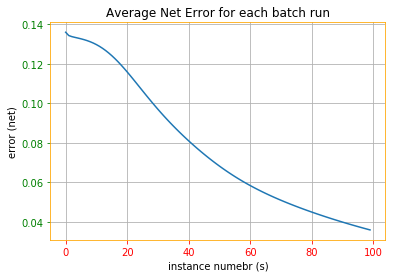

In [206]:
netPlot(numberProcess, batchError)

In [190]:
# remember for this set you target yes as 1 and no as 0, confusing I know
weightMap = load_objects("./FishWeights.pkl")
theta1 = weightMap["theta1"]
theta2 = weightMap["theta2"]

test = getArrayFromFile("normalizeFishTest.csv")
print(test)
print(test.shape)
test = getInputs(test)

testInstance = test

classifyFish(testInstance, theta1, theta2)


[0. 0. 0. 1. 0. 1. 0. 0.]
(8,)
[1.]
		Layer One activations: 
[-0.4560759  -1.8905096  -1.49066094  1.05197795 -1.30777151  0.86557503
 -1.93706421]

		Sigmoid Result: [0.38791714 0.13118638 0.18382255 0.74115454 0.21285999 0.70382412
 0.12597074]

[1.]
		Inputs for the hiden layer is: (b,h1,h2)
[1.         0.38791714 0.13118638 0.18382255 0.74115454 0.21285999
 0.70382412 0.12597074]

		Activation for output layer: (h1,h2)
[0.61300909]

		Final output: 
[0.64862691]



'Yes'